In [8]:
import os
os.chdir("../")
import numpy as np
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.factory.config_factory import cfg, show_configs
from src.factory.data_factory import DataFactory
from src.factory.data_format_factory import DataFormatFactory
from src.factory.transform_factory import TransformFactory
from src.factory.loader_factory import LoaderFactory
from src.base_data import BaseData
from tools.logger import setup_logger
logger = setup_logger("./external/")

from tools.scopehead_utils import scopehead_bbox_target

In [2]:
cfg.NUM_WORKERS = 1
cfg.DB.PATH = "/home/agent/person_jde"
cfg.DB.DATA = "crowdhuman"
cfg.DB.DATA_FORMAT = "coco"
cfg.DB.TARGET_FORMAT = "scopehead"
cfg.DB.LOADER = "coco"
cfg.DB.USE_TRAIN = True
cfg.DB.USE_TEST = False
cfg.INPUT.SIZE = (576, 320)
cfg.INPUT.TRAIN_BS = 1
cfg.MODEL.STRIDES = [1]
cfg.DB.TRAIN_TRANSFORM = "ResizeKeepAspectRatio" #RandScale RandomColorJitter-1.0-0.8-0.15-0.1-0.1 RandomRotate-1"
cfg.DB.TEST_TRANSFORM = "Resize Tensorize"
cfg.REID.MSMT_ALL = False
cfg.COCO.TARGET = 'person'
# cfg.YOLO.ANCHORS = [6,16, 8,23, 11,32, 16,45,   21,64, 30,90, 43,128, 60,180,   85,255, 120,360, 170,420, 340, 320]


In [9]:
data = DataFactory.produce(cfg, cfg.DB.PATH, cfg.DB.DATA, 'person', 0, 1, [1], None, True, False)
trans = TransformFactory.produce(cfg, cfg.DB.TRAIN_TRANSFORM)
dataset = DataFormatFactory.produce(cfg, data.train, trans, scopehead_bbox_target)

loading annotations into memory...
Done (t=1.67s)
creating index...
index created!
2020-05-25 06:42:35,574 25966 coco.py INFO: => CROWDHUMAN TRAIN is loaded
2020-05-25 06:42:35,576 25966 coco.py INFO:   Dataset statistics:
2020-05-25 06:42:35,578 25966 coco.py INFO:   -----------------------------
2020-05-25 06:42:35,579 25966 coco.py INFO:   subset   | #id     | # images
2020-05-25 06:42:35,580 25966 coco.py INFO:   -----------------------------
2020-05-25 06:42:35,581 25966 coco.py INFO:   train    |       0 |    14982
2020-05-25 06:42:35,582 25966 coco.py INFO:   -----------------------------


In [122]:
import math
def rotate_A(level, shape, **kwargs):
    # copy from https://pillow.readthedocs.io/en/stable/_modules/PIL/Image.html#Image.rotate
    angle = level % 360.0

    w, h = shape

    post_trans = (0, 0)
    rotn_center = (w / 2.0, h / 2.0)
    angle = math.radians(angle)
    matrix = [
        round(math.cos(angle), 15),
        round(math.sin(angle), 15),
        0.0,
        round(-math.sin(angle), 15),
        round(math.cos(angle), 15),
        0.0,
    ]

    def transform(x, y, matrix):
        (a, b, c, d, e, f) = matrix
        return a * x + b * y + c, d * x + e * y + f

    matrix[2], matrix[5] = transform(
        -rotn_center[0] - post_trans[0], -rotn_center[1] - post_trans[1], matrix
    )
    matrix[2] += rotn_center[0]
    matrix[5] += rotn_center[1]

    return np.array(matrix).reshape(2, 3).astype(np.float)
def apply_A(pt, A):
    new_pt = np.array([pt[0], pt[1], 1.], dtype=np.float32).T
    new_pt = np.dot(A, new_pt)
    return new_pt[:2]

In [18]:
from tools.utils import _tranpose_and_gather_feat

In [31]:
wh = batch[(576,320)]['wh'].unsqueeze(0)
ind = batch[(576,320)]['ind'].unsqueeze(0)
reg_mask = batch[(576,320)]['reg_ㄋㄩㄜ].unsqueeze(0)

In [26]:
output = torch.rand(1,20,320,576)

In [34]:
_tranpose_and_gather_feat(output, ind).shape

torch.Size([1, 100, 20])

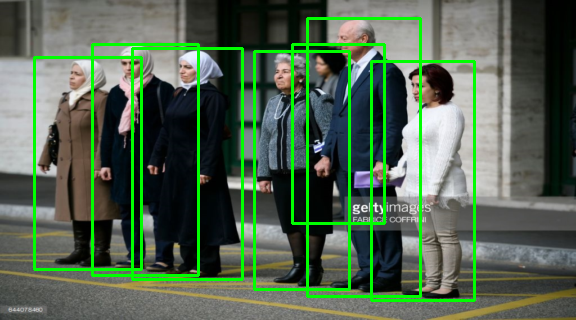

In [15]:
batch = dataset[0]
# h, w = batch['inp'].shape[:2]
w, h = batch['inp'].size
# angle = 150
img = batch['inp']#.rotate(angle)
np_img = np.array(img).astype(np.uint8)
np_img = cv2.resize(np_img, (w, h))
# A = rotate_A(angle, (w, h))
for bbox in batch['bboxes']:
    x1, x2 = (bbox[[0,2]] * w).astype(int)
    y1, y2 = (bbox[[1,3]] * h).astype(int)
    # tlx, brx = (bbox[[0,2]] * w).astype(int)
    # tly, bry = (bbox[[1,3]] * h).astype(int)
    # trx, blx = brx, tlx
    # tr_y, bly = tly, bry
    # tlx, tly = apply_A([tlx, tly], A).astype(int)
    # brx, bry = apply_A([brx, bry], A).astype(int)
    # trx, tr_y = apply_A([trx, tr_y], A).astype(int)
    # blx, bly = apply_A([blx, bly], A).astype(int)
    # x1 = np.array([tlx, trx, blx, brx]).min()
    # y1 = np.array([tly, tr_y, bly, bry]).min()
    # x2 = np.array([tlx, trx, blx, brx]).max()
    # y2 = np.array([tly, tr_y, bly, bry]).max()
    cv2.rectangle(np_img, (x1, y1), (x2, y2), (0,255,0), 2)
Image.fromarray(np_img)

In [7]:
data_names = cfg.DB.DATA.split(" ")
handles = []
indice = []
pids = []
offset = 0
for idx, name in enumerate(data_names):
    data = DataFactory.produce(cfg, data_name=name)
    handles.append(data.train['handle'])
    pids.append(data.train['pid'])
    for img_id, img_path in data.train['indice']:
        indice.append((img_id, img_path, idx, offset))
    offset += (max(list(data.train['pid'].values())) + 1)

_data = BaseData()
_data.train['handle'] = handles
_data.train['indice'] = indice
_data.train['pid'] = pids
_data.train['strides'] = cfg.MODEL.STRIDES
_data.train['num_classes'] = offset
_data.train['num_keypoints'] = 0
_data.train['num_person'] = 0
cfg.DB.NUM_CLASSES = offset

trans = TransformFactory.produce(cfg, cfg.DB.TRAIN_TRANSFORM)
dataset = DataFormatFactory.produce(cfg, _data.train, trans)

TypeError: produce() got an unexpected keyword argument 'data_name'

In [4]:
batch = dataset[0]

In [3]:
loader = LoaderFactory.produce(cfg)


loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
2020-04-08 17:36:03,851 25861 coco.py INFO: => COCO TRAIN is loaded
2020-04-08 17:36:03,853 25861 coco.py INFO:   Dataset statistics:
2020-04-08 17:36:03,854 25861 coco.py INFO:   -------------------
2020-04-08 17:36:03,855 25861 coco.py INFO:   subset   | # images
2020-04-08 17:36:03,855 25861 coco.py INFO:   -------------------
2020-04-08 17:36:03,856 25861 coco.py INFO:   train    |     2056
2020-04-08 17:36:03,857 25861 coco.py INFO:   -------------------


In [6]:
import pycocotools.coco as coco
import json
import os
import os.path as osp
from PIL import Image
from tqdm import tqdm
import numpy as np
import shutil
import cv2

from tools.yolov3_utils import decode_delta_map


In [4]:
batch = next(iter(loader['train']))
batch['bboxes']
bboxes = np.vstack(batch['bboxes'])
bboxes[:, [0,2]] *= 576
bboxes[:, [1,3]] *= 320

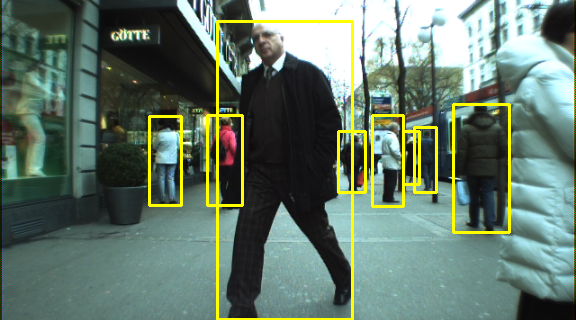

In [7]:
batch = next(iter(loader['train']))
batch['bboxes']
bboxes = np.vstack(batch['bboxes'])
bboxes[:, [0,2]] *= 576
bboxes[:, [1,3]] *= 320
np_img = (batch['inp']*255).squeeze().permute(1,2,0).numpy().astype(np.uint8)
np_img = cv2.resize(np_img, (576,320))
Image.fromarray(np_img)
for b in bboxes:
    x1, y1, x2, y2 = b
    cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
Image.fromarray(np_img)

tensor(5) 72x40
tensor(34) 36x20
tensor(16) 18x10


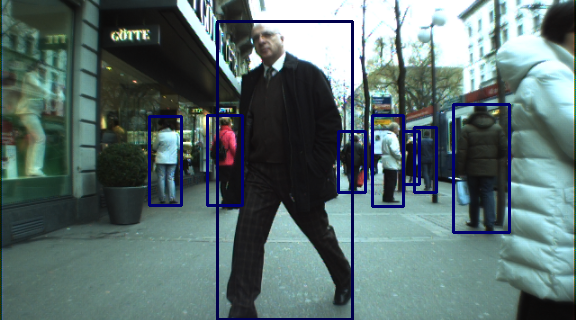

In [8]:
shapes = ['72x40', '36x20', '18x10']
anchors = torch.Tensor(cfg.YOLO.ANCHORS).view(len(cfg.MODEL.STRIDES), -1, 2)
for stage, shape in enumerate(shapes):
    mask = batch[f"yolov3_{shape}_t_conf"] > 0
    t_bbox = batch[f"yolov3_{shape}_t_bbox"]
    print(mask.sum(), shape)
    target_anchors = anchors[stage] / cfg.MODEL.STRIDES[stage]
    p_bbox = decode_delta_map(t_bbox, target_anchors)[mask] * cfg.MODEL.STRIDES[stage]
    p_bbox[:,0] -= p_bbox[:,2] / 2
    p_bbox[:,1] -= p_bbox[:,3] / 2
    for b in p_bbox:
        x1, y1, w, h = b
        cv2.rectangle(np_img, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (0,0,225//(stage+1)), 2)
Image.fromarray(np_img)